# Прогнозирование ряда со сложной сезонностью

In [74]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
from tqdm.notebook import tqdm_notebook as tqdm
import matplotlib.pyplot as plt
from scipy import stats
from tqdm.notebook import tqdm
import numpy as np
from sklearn.linear_model import Lasso, LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import statsmodels.api as sm
from datetime import timedelta
from itertools import product

%pylab inline

from datetime import datetime

Populating the interactive namespace from numpy and matplotlib


Выберем зону 1231 и возьмем по ней все подготовленные данные о количестве поездок.

In [3]:
df = pd.read_pickle(f'data/agg/1231.pkl')
df.index = df.pickup_datetime
del df['pickup_datetime']
df.head()

,trips
pickup_datetime,
2014-05-01 00:00:00,611
2014-05-01 01:00:00,370
2014-05-01 02:00:00,233
2014-05-01 03:00:00,174
2014-05-01 04:00:00,140


In [5]:
start_date = datetime(2016, 1, 1)
end_date = pd.Timestamp('2016-06-01T00:00:00Z').tz_localize(None)

In [8]:
df = df[df.index < end_date]
df = df[df.index > start_date]
len(df)

3647

Создадим функцию для генерации регрессионных признакох для учёта сезонностей и трендов.

In [11]:
def sin_cos_features(lag, K, length):
    res = []
    for i in range(K):
        res.append(np.sin(np.arange(length) * 2 * np.pi * i / lag))
    for i in range(K):
        res.append(np.cos(np.arange(length) * 2 * np.pi * i / lag))
    
    return np.array(res).T

Дополнительно рассмотрим признаки праздничных дней и снежного шторма

In [12]:
from pandas.tseries.holiday import USFederalHolidayCalendar
cal = USFederalHolidayCalendar()
holidays = cal.holidays(start=start_date, end=end_date).to_pydatetime().tolist()

def is_holiday(timestamp, holidays=holidays):
    return timestamp.tz_localize(None).floor('d') in holidays

def is_snowstorm(timestamp):
    snowstorms = [datetime(2015, 1, 26), datetime(2015, 1, 27), 
                  datetime(2015, 3, 1), datetime(2015, 3, 5),
                  datetime(2016, 1, 22), datetime(2016, 1, 23), datetime(2016, 1, 24)]
    return timestamp.tz_localize(None).floor('d') in snowstorms

def is_new_year(timestamp):
    snowstorms = [datetime(2014, 12, 31), datetime(2015, 1, 1),
                  datetime(2015, 12, 31), datetime(2016, 1, 1)]
    return timestamp.tz_localize(None).floor('d') in snowstorms

In [14]:
def datetime_features(df):
    weekday = df.index.weekday
    week_end = df.index.weekday > 4
    working_day = df.index.weekday < 5
    holiday = df.index.map(is_holiday)
    snowstorm = df.index.map(is_snowstorm)
    new_year = df.index.map(is_new_year)
    return np.array([weekday, week_end, working_day, holiday, snowstorm, new_year]).T

In [15]:
dt_features = datetime_features(df)

Попробуем определить какое количество гармонических признаков будет оптимальным

In [17]:
errors = []
for k in range(1, 60):
    clf = Lasso()
    X = np.hstack([sin_cos_features(168, k, len(df)),
                   sin_cos_features(8766, k, len(df)),
                   dt_features])
    y = df.trips.values
    clf.fit(X, y)
    
    errors.append(mean_squared_error(y, clf.predict(X)))

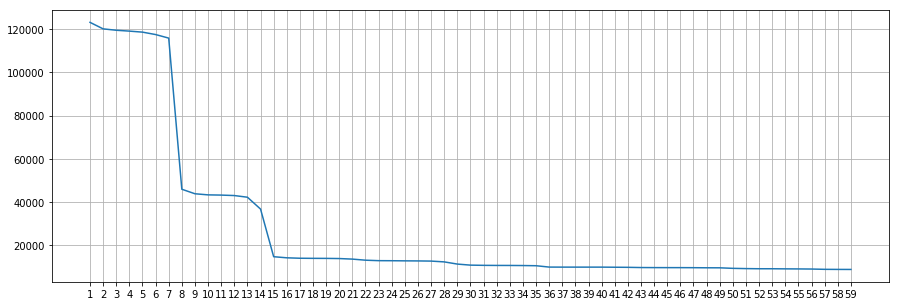

In [18]:
plt.figure(figsize(15,5))
plt.plot(range(1, 60), errors)
plt.xticks(range(1, 60))
_=plt.grid(True)

Видно что после значения 36 значение метрики практически не уменьшается. Сделаем финальную регресию на полученые признаки.

In [76]:
X = np.hstack([sin_cos_features(168, 36, len(df)),
               sin_cos_features(8766, 36, len(df)),
               dt_features, np.arange(1, len(df) + 1).reshape((len(df), 1))])
y = df.trips.values
clf = Lasso()
clf.fit(X, y)
df['resid'] = y - clf.predict(X)

In [21]:
clf.score(X, y)

0.9221933909783244

Посмотрим не остатки

<Figure size 1080x720 with 0 Axes>

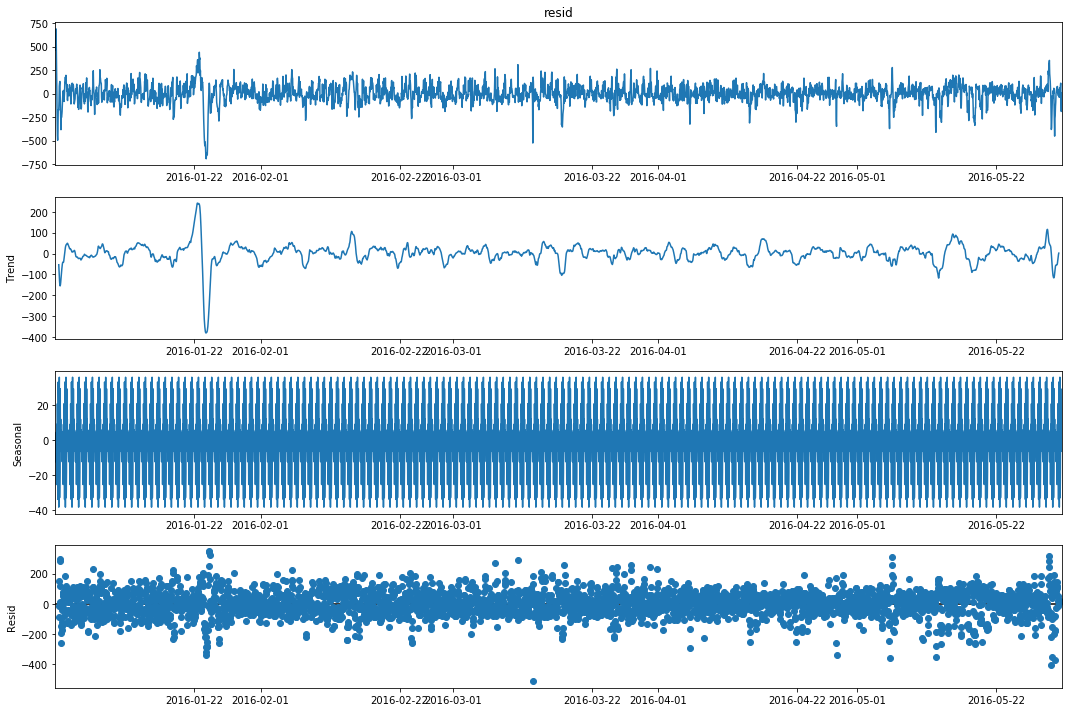

In [24]:
plt.figure(figsize(15,10))
_=sm.tsa.seasonal_decompose(df['resid']).plot()

In [25]:
print("Критерий Дики-Фуллера:")
sm.tsa.stattools.adfuller(df['resid'])

Критерий Дики-Фуллера:


(-11.876778484632156,
 6.313722476030354e-22,
 29,
 3617,
 {'1%': -3.4321592195007473,
  '5%': -2.8623394121216172,
  '10%': -2.5671955395660633},
 40673.29881746451)

Остатки не смещены и кртерий Дики-Фуллера говорит о их стационарности

Посмотрим на графики автокоррлеляци после одного обычного и одного сезонного дифференцирования

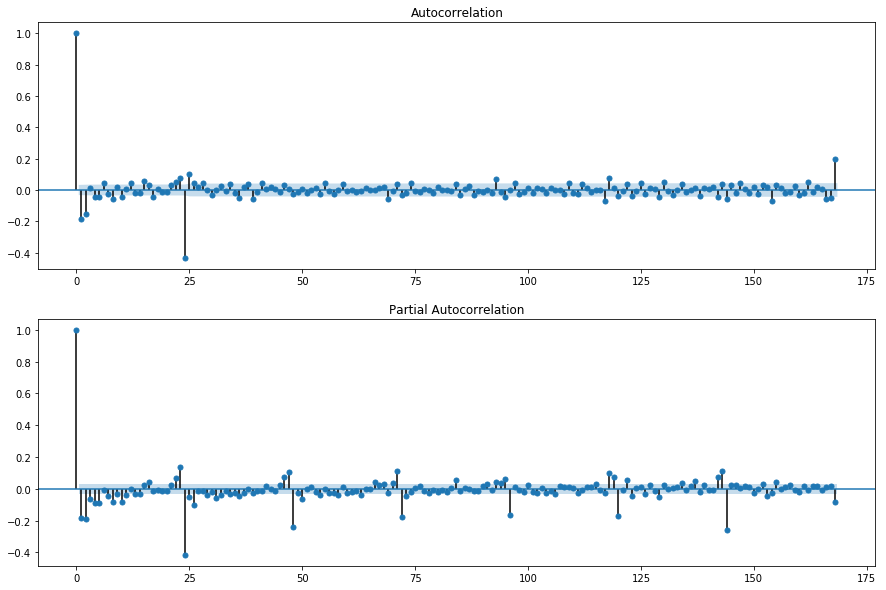

In [31]:
df['resid_1'] = df.resid - df.resid.shift(1)
df['resid_24'] = df.resid_1 - df.resid_1.shift(24)

fig, ax = plt.subplots(2,1,figsize=(15,10))
sm.graphics.tsa.plot_acf(df['resid_24'].dropna().values.squeeze(), lags=168, ax=ax[0])
sm.graphics.tsa.plot_pacf(df['resid_24'].dropna().values.squeeze(), lags=168, ax=ax[1])
plt.show()

### Начальное приближение

d=1, D=1, Q=1, q=2, P=6, p=2

Подберём оптимальную модель SARIMAX.

In [54]:
Qs = range(1, 2)
qs = range(1, 3)
d = 1
Ps = range(5, 7)
ps = range(1, 3)
D = 1

In [55]:
from itertools import product
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

8

In [56]:
parameters_list

[(1, 1, 5, 1),
 (1, 1, 6, 1),
 (1, 2, 5, 1),
 (1, 2, 6, 1),
 (2, 1, 5, 1),
 (2, 1, 6, 1),
 (2, 2, 5, 1),
 (2, 2, 6, 1)]

In [64]:
%%time
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')

prev_model = None

for param in tqdm(parameters_list):
    #try except нужен, потому что на некоторых наборах параметров модель не обучается
    try:
        model=sm.tsa.statespace.SARIMAX(df.resid, order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 24))
        
        if prev_model is None:
            model = model.fit(disp=-1)
        else:
            model = model.fit(disp=-1, params=prev_model.params)
        prev_model = model
    #выводим параметры, на которых модель не обучается и переходим к следующему набору
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    #сохраняем лучшую модель, aic, параметры
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])
    
warnings.filterwarnings('default')


CPU times: user 2h 33min 44s, sys: 7min 29s, total: 2h 41min 14s
Wall time: 1h 27min 16s


In [65]:
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())

     parameters           aic
3  (1, 2, 6, 1)  40626.066671
1  (1, 1, 6, 1)  40626.119063
5  (2, 1, 6, 1)  40626.136833
7  (2, 2, 6, 1)  40630.565106
2  (1, 2, 5, 1)  40773.769869


In [66]:
print(best_model.summary())

                                      SARIMAX Results                                       
Dep. Variable:                                resid   No. Observations:                 3647
Model:             SARIMAX(1, 1, 2)x(6, 1, [1], 24)   Log Likelihood              -20302.033
Date:                              Thu, 04 Mar 2021   AIC                          40626.067
Time:                                      22:48:43   BIC                          40694.209
Sample:                                  01-01-2016   HQIC                         40650.344
                                       - 05-31-2016                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7640      0.011     71.195      0.000       0.743       0.785
ma.L1         -1.04

Критерий Стьюдента: p=0.349528
Критерий Дики-Фуллера: p=0.000000


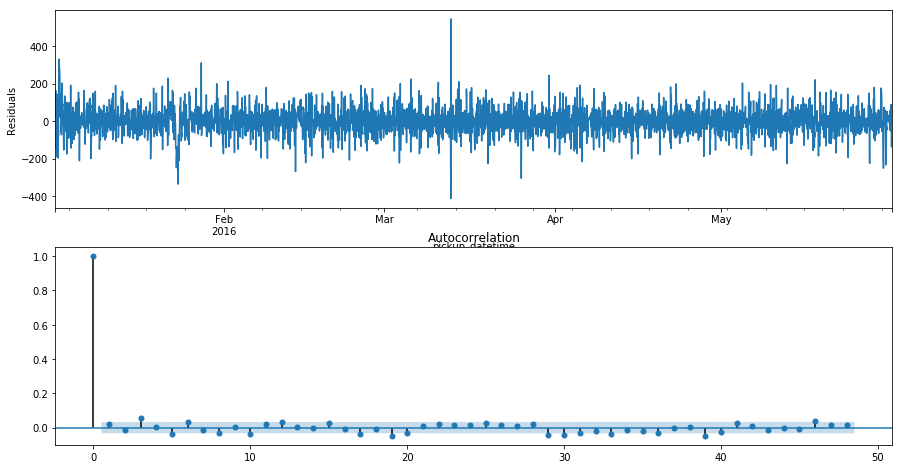

In [67]:
plt.figure(figsize(15,8))
plt.subplot(211)
best_model.resid[13:].plot()
plt.ylabel(u'Residuals')

ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(best_model.resid[13:].values.squeeze(), lags=48, ax=ax)

print("Критерий Стьюдента: p=%f" % stats.ttest_1samp(best_model.resid[13:], 0)[1])
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(best_model.resid[13:])[1])

Остатки несмещены. Переходим к проверке предсказаний

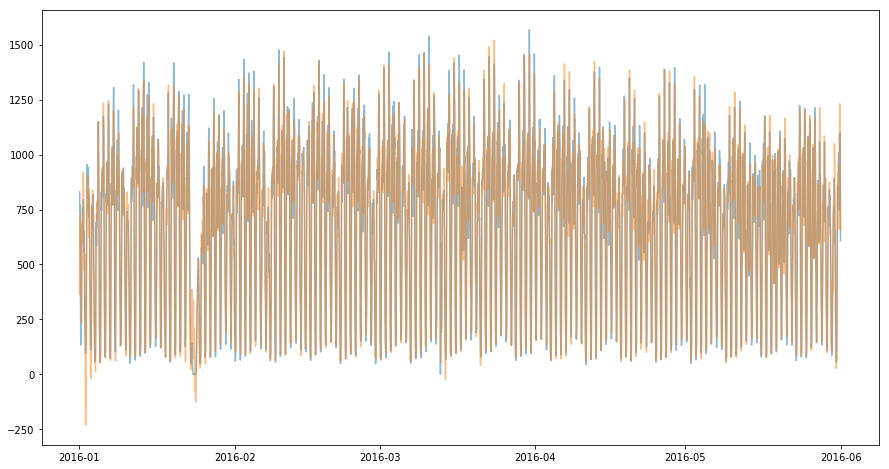

In [72]:
plt.plot(df.trips, alpha = 0.5, label='True')
plt.plot(clf.predict(X) + best_model.fittedvalues, alpha = 0.5, label='Predicted')

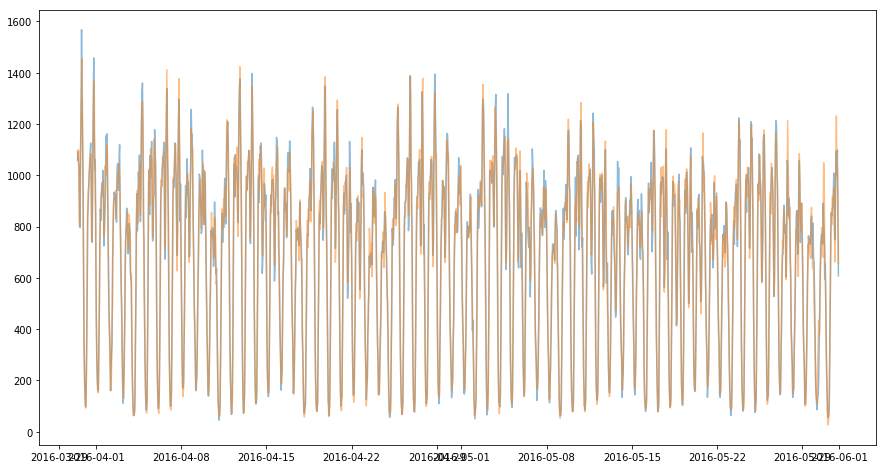

In [73]:
plt.plot(df.trips[-1500:], alpha = 0.5, label='True')
plt.plot((clf.predict(X) + best_model.fittedvalues)[-1500:], alpha = 0.5, label='Predicted')

In [77]:
r2_score(df.trips, clf.predict(X) + best_model.fittedvalues)

0.9644475398151588

Модель достаточно хорошо предсказывает ряд и коэффициент детерминации высокий. Тем не менее во время снежной бури она ошибается больше всего.